# One-dimensional bandwidth sweep

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax.scipy.stats import norm

import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import dict_concatenate, dict_mean
from tqdm import tqdm
import time

# from svgd import SVGD
import svgd
import metrics
import utils
import plot

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
dist = metrics.Gaussian(0, 6)
dist.ksd_grid = (0.01, 0.1, 1, 40, 100)
dist.initialize_metric_names()
n = 100
d = dist.d
# svgd_main = SVGD(dist, n_steps, particle_shape=(n, d), adagrad=False)

grid_length = 40
# bandwidth_grid = np.linspace(0.5, 100, num=grid_length)
bandwidth_grid = np.logspace(-1, 3, num=grid_length, base=10)

lr = 0.01
svgd_stepsize = 1

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


  0%|          | 1/200 [00:01<05:48,  1.75s/it]

JIT COMPILING step...
...done compiling step after 0.3813464641571045 seconds.


100%|██████████| 200/200 [00:08<00:00, 23.46it/s]


took 8.876405715942383 seconds
[7.0993166 7.1706657 7.242732  7.3155227]


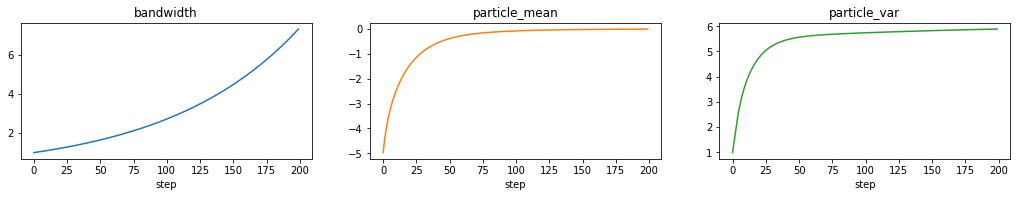

In [3]:
"""run SVGD.train() for L0 steps"""
L0 = 200
svgd0 = svgd.SVGD(dist, L0, particle_shape=(n, d), adagrad=False)
h0 = 1
ksd_bandwidth = 40
lr = 0.01
svgd_stepsize = 1
rkey = random.split(rkey)[0]

st = time.time()
x, log, losses = svgd0.train(rkey, h0, lr, svgd_stepsize, L0, ksd_bandwidth, update_after=0)
x.block_until_ready()
end = time.time()
print(f"took {end - st} seconds")
print(log["desc"]["bandwidth"][-4:][:, 0])

current_h = log["desc"]["bandwidth"][-4:][-1, 0]

plot.svgd_log(log)

## sweep

In [4]:
def get_metrics(rkey, h):
    """get metrics (incl loss) from SVGD.step"""
    xout = svgd.update(x, dist.logpdf, svgd_stepsize, h, None, False, None)
    return dist.compute_metrics(xout)

In [5]:
def sweep(rkey, grid):
    """Sweep a grid of bandwidth values and output corresponding metrics."""
    sweep_results = []
    for h in grid:
        metrics = get_metrics(rkey, h)
        sweep_results.append(metrics)
    return {k: np.stack([metrics[k] for metrics in sweep_results], axis=0) for k in dist.metric_names.keys()}
# entries in dict have shapes (k, 3, d) and (k, 3)

In [6]:
m = 1
metrics_sweep = []
sweeps = []
for i in tqdm(range(m)):
#     print(f"Sweep {i+1} of {m}")
    rkey = random.split(rkey)[0]
    s = sweep(rkey, bandwidth_grid)
    sweeps.append(s)

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


In [7]:
sweeps = dict_mean(sweeps)

current bandwidth: 7.3155227


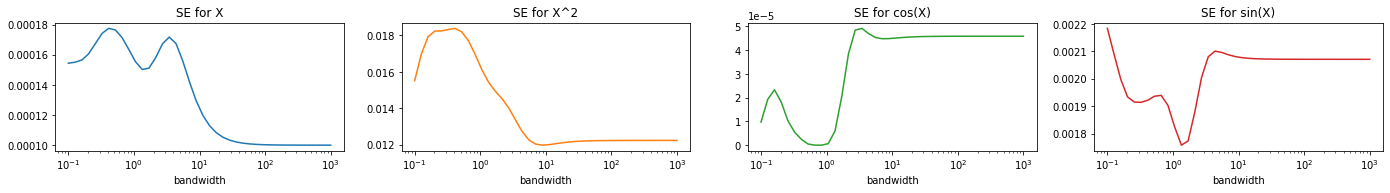

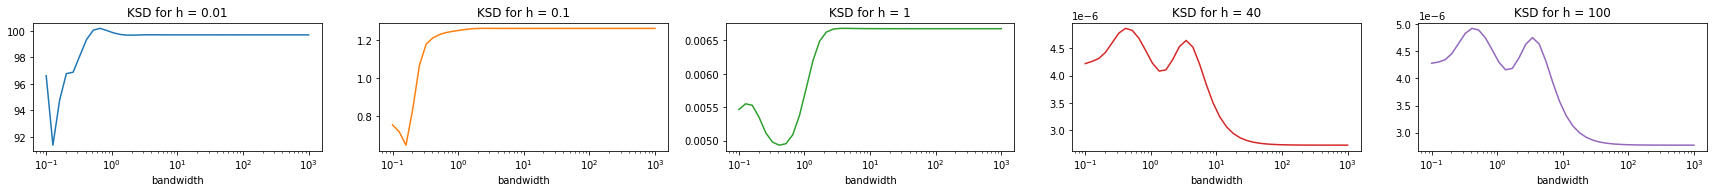

In [8]:
print("current bandwidth:", current_h)
for k, v in sweeps.items():
    plot.plotobject(np.rollaxis(v, axis=1), xaxis=bandwidth_grid, titles=dist.metric_names[k], 
                    xscale="log", xlabel="bandwidth")

(array([ 2.,  1.,  7., 10., 16., 18., 19., 12.,  5., 10.]),
 array([-6.5767474 , -5.4402075 , -4.3036675 , -3.1671274 , -2.0305874 ,
        -0.8940475 ,  0.24249248,  1.3790325 ,  2.5155725 ,  3.6521125 ,
         4.7886524 ], dtype=float32),
 <a list of 10 Patch objects>)

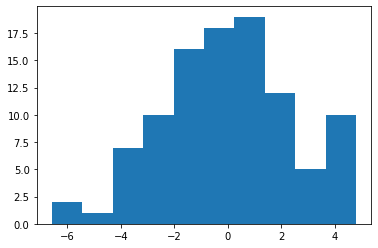

In [9]:
plt.hist(x[:, 0])

In [10]:
dist.compute_metrics(x)

{'square_errors': DeviceArray([[1.4417636e-04],
              [1.2227613e-02],
              [4.4586977e-05],
              [2.0812587e-03]], dtype=float32),
 'ksds': DeviceArray([9.9695564e+01, 1.2618411e+00, 6.6761989e-03, 3.8919411e-06,
              3.9856382e-06], dtype=float32)}